In [73]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from dgl.nn import EGATConv, EdgeWeightNorm, GraphConv
from dgl.utils import expand_as_pair
import time
from config import Config
torch.set_default_dtype(torch.float32)
import networkx as nx


In [111]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from config import Config
from data import part_DATA
from utils import torchUniform, A_cluster, set_seed, act

class AnnRC(nn.Module):
    '''
    Artificial-Neuron Version of Reservoir Computing Model in pytorch implementation
    Multi-layer with serial structure
    TODO how to train self.ff1 and self.ff2?
    '''
    def __init__(self, config:Config) -> None:
        super(AnnRC, self).__init__()
        self.config = config
        self.N_in = config.N_in
        self.N_hid = config.N_hid
        self.mem_init = config.mem_init
        self.alpha = config.alpha
        self.frames = config.frames
        self.device = config.device
        self.layers = config.layers
        
        Win = config.Win
        self.ff_in = nn.Linear(self.N_in, self.N_hid, bias=True)
        # self.W_in1 = nn.Parameter(torchUniform(-Win, Win, size=(self.N_in, self.N_hid))).to(self.device)
        self.ff_A = nn.Linear(self.N_hid, self.N_hid, bias=False)
        self.ff_A.weight = nn.Parameter(torch.tensor(A_cluster(config)))
        # self.A1 = nn.Parameter(torch.tensor(A_cluster(config))).to(self.device)
        # self.bias1 = nn.Parameter(torchUniform(-config.bias, config.bias, size=(self.N_hid))).to(self.device)
        
        self.fc = nn.Linear(self.N_hid, config.N_out)
        self.fc1 = nn.Linear(self.N_hid, 128)
        self.fc2 = nn.Linear(128, config.N_out)
        
        # self.W_in2 = torchUniform(-Win, Win, size=(self.N_hid, self.N_hid)).to(self.device)
        # self.A2 = torch.tensor(A_cluster(config)).to(self.device)
        # self.bias2 = torchUniform(-config.bias, config.bias, size=(self.N_hid)).to(self.device)
        
        # self.gelu = nn.GELU()
        # self.ff1 = nn.Linear(self.N_hid, self.N_hid)
        # self.ff2 = nn.Linear(self.N_hid, self.N_hid)
        
        # self.layernorm = nn.LayerNorm()
        set_seed(config)
    
    def forward(self, x):
        '''
        inference function of spiking version
        x: input tensor [batch, frames, N_in]
        
        return
        r:        [batch, frames, N_hid]
        '''
        batch = x.shape[0]
        device = self.device
        
        r = torch.zeros(self.layers, batch, self.frames+1, self.N_hid).to(device)
        r[0,:,0,:] = torchUniform(-self.mem_init, self.mem_init, size=(batch, self.N_hid)).to(device) # layer1
        a = torchUniform(-self.mem_init, self.mem_init, size=(batch, self.N_hid)).to(device)
        # r[1,:,0,:] = torchUniform(-self.mem_init, self.mem_init, size=(batch, self.N_hid)).to(device) # layer2
        
        for t in range(self.frames):
            # layer 1
            # U = torch.mm(x[:,t,:], self.W_in1) # (batch, N_hid)
            U = self.ff_in(x[:,t,:])
            # r_ = torch.mm(r[0,:,t,:], self.A1) # information from neighbors (batch, N_hid)
            # y = self.alpha * r[0,:,t,:] + (1-self.alpha) * act(r_ +  U + self.bias1)
            # r[0,:,t+1,:] = y
            
            # r_ = torch.mm(a, self.A1) # information from neighbors (batch, N_hid)
            r_ = self.ff_A(a)
            y = self.alpha * a + (1-self.alpha) * act(r_ + 0.1*U) # + self.bias1
            a = y
        out = F.relu(self.fc1(y))
        out = self.fc2(out)
        return out

Data Generation Finish
[8, 80, 0, 1, 65, 25, 20, 42, 44, 40]


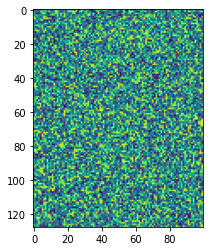

In [112]:
Config.N_hid = 100
Config.batch_size = 20
Config.train_num = 1000
Config.test_num = 1000
Config.frames = 10
Config.lr = 1e-4
Config.epoch = 200
train_loader, test_loader = part_DATA(Config)
model = AnnRC(Config).to(Config.device)

A_before = model.ff_A.weight.cpu().detach().numpy()
Win_before = model.ff_in.weight.cpu().detach().numpy()
fcw_before = model.fc1.weight.cpu().detach().numpy()
fcb_before = model.fc1.bias.cpu().detach().numpy()
index = model.ff_A.weight==0
plt.imshow(fcw_before)

G = nx.from_numpy_matrix(A_before, create_using=nx.DiGraph)
ecen = nx.degree_centrality(G)
sorted_ecen = sorted(ecen.items(), key = lambda kv:(kv[1], kv[0]))
node_list = [i[0] for i in sorted_ecen[-10:]]
print(node_list)

In [113]:
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)
# torch.autograd.set_detect_anomaly(True)
for e in range(Config.epoch):
    train_loss = 0
    train_correct = 0
    for i, (img, label) in enumerate(train_loader):
        batch = img.shape[0]
        x_enc = None
        for _ in range(Config.frames):
            spike = (img > torch.rand(img.size())).float()
            if x_enc is None: x_enc = spike
            else: x_enc = torch.cat((x_enc, spike), dim=1)
        x_enc = x_enc.view(batch, Config.frames, Config.N_in) # [batch, frames, N_in]
        out = model(x_enc.to(Config.device))    
        optimizer.zero_grad()
        loss = cost(out, label.to(Config.device))
        loss.backward()
        optimizer.step()
        train_loss += loss.cpu().item()
        with torch.no_grad():
            model.ff_A.weight[index] = 0
            for i in node_list:
                model.ff_A.weight[i,:] = 0
                model.ff_A.weight[:,i] = 0
        
        _, id = torch.max(out.data, 1)
        train_correct += torch.sum(id.cpu()==label.data)
    
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        model.ff_A.weight[index] = 0
        for i, (img, label) in enumerate(test_loader):
            batch = img.shape[0]
            x_enc = None
            for _ in range(Config.frames):
                spike = (img > torch.rand(img.size())).float()
                if x_enc is None: x_enc = spike
                else: x_enc = torch.cat((x_enc, spike), dim=1)
            x_enc = x_enc.view(batch, Config.frames, Config.N_in) # [batch, frames, N_in]
            out = model(x_enc.to(Config.device))
            loss = cost(out, label.to(Config.device))
            test_loss += loss.cpu().item()
            
            _, id = torch.max(out.data, 1)
            test_correct += torch.sum(id.cpu()==label.data)
    print(e, 
          train_loss/(Config.train_num/Config.batch_size), 
          test_loss/(Config.test_num/Config.batch_size), 
          train_correct.item()/Config.train_num, 
          test_correct.item()/Config.test_num)

0 2.313421673774719 2.3003085470199585 0.099 0.108
1 2.2967870092391967 2.2997748136520384 0.116 0.102
2 2.288603439331055 2.288862371444702 0.13 0.132
3 2.2752161121368406 2.2770478439331057 0.156 0.147
4 2.2584733867645266 2.255523056983948 0.175 0.167
5 2.2362822008132937 2.2420627069473267 0.183 0.175
6 2.194757719039917 2.1929774284362793 0.237 0.224
7 2.146653311252594 2.1321959829330446 0.235 0.257
8 2.086826596260071 2.081156268119812 0.298 0.268
9 2.0247182989120485 2.035696978569031 0.296 0.274
10 1.9652865386009217 1.9721504712104798 0.304 0.282
11 1.8995840978622436 1.9001549005508422 0.348 0.322
12 1.8060536551475526 1.8169633889198302 0.368 0.352
13 1.7427383041381836 1.758104293346405 0.374 0.377
14 1.6745648956298829 1.7102688026428223 0.393 0.37
15 1.6116106772422791 1.6281820368766784 0.416 0.402
16 1.5578457450866698 1.5998035407066344 0.438 0.432
17 1.4985606646537781 1.5436578917503356 0.458 0.434
18 1.4563076186180115 1.509752357006073 0.482 0.459
19 1.40215720891

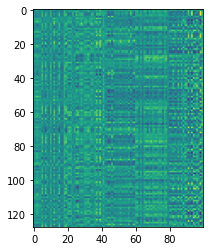

In [70]:
A_after = model.ff_A.weight.cpu().detach().numpy()
Win_after = model.ff_in.weight.cpu().detach().numpy()
fcw_after = model.fc1.weight.cpu().detach().numpy()
fcb_after = model.fc1.bias.cpu().detach().numpy()
# plt.imshow(A_after_train)
plt.imshow(fcw_before-fcw_after)

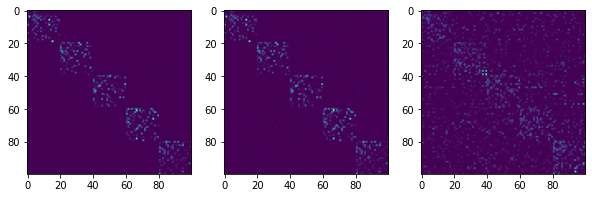

In [71]:
plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(np.abs(A_before))
plt.subplot(132)
plt.imshow(np.abs(A_after))
plt.subplot(133)
plt.imshow(np.abs(A_after-A_before))

In [2]:
from train_gpu import inference_new, train_transformer_readout
run_time = time.strftime("%Y.%m.%d-%H-%M-%S", time.localtime())
# param_search(run_time)
from config import Config
from data import part_DATA
from RC import torchRC, EGAT, EGCN
import dgl
from RC import MLP, Transformer

config = Config()
config.device = 'cuda:0'
config.data = 'mnist'
config.train_num = 50000
config.test_num = 10000
config.N_in = 28*28
config.N_hid = 100
config.N_out = 10
train_loader, test_loader = part_DATA(config)

model = torchRC(config).to(config.device)
train_rs, train_label = inference_new(model, config, train_loader,)
test_rs, test_label = inference_new(model, config, test_loader,)

Data Generation Finish
finish inference
finish inference


In [3]:
config.d_model = 64
config.encoder_layer = 2 # 增加encoder层数能略微增加性能
config.n_heads = 8 # d_model不变，增加n_head能略微增加性能，貌似比encoder_layer管用
config.d_ff = 64

config.lr = 1e-3
config.epoch = 500
config.batch_size = 50

model = Transformer(config).to(config.device)
print('model parameter:', sum(p.numel() for p in model.parameters() if p.requires_grad))


model parameter: 56896


In [48]:
X_train = train_rs[:,1:,0:config.N_hid]
y_train = train_label
X_test = test_rs[:,1:,0:config.N_hid]
y_test = test_label
train_num = X_train.shape[0]
test_num = X_test.shape[0]
iteration = int(train_num/config.batch_size)
iter = int(test_num/config.batch_size)
cost = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

train_loss, test_loss, train_acc, test_acc = [], [], [], []
for epoch in range(config.epoch) :
    model.train()
    sum_loss = 0
    train_correct = 0
    for i in range(iteration):
        x = X_train[i*config.batch_size:(i+1)*config.batch_size] # [batch, config.frames, config.N_hid]
        y = y_train[i*config.batch_size:(i+1)*config.batch_size]
        out = model(x)

        optimizer.zero_grad()
        loss = cost(out, y)
        loss.backward()
        optimizer.step()

        _, id = torch.max(out.data, 1)
        sum_loss += loss.data
        train_correct+=torch.sum(id==y.data)
    
    model.eval()
    test_correct = 0
    for i in range(iter):
        x = X_test[i*config.batch_size:(i+1)*config.batch_size]
        y = y_test[i*config.batch_size:(i+1)*config.batch_size]
        out = model(x)
        loss = cost(out, y)
        _, id = torch.max(out.data, 1)
        test_correct += torch.sum(id == y.data)
        
    train_loss.append(sum_loss.cpu()/iteration)
    test_loss.append(loss.cpu()/iter)
    train_acc.append(train_correct.cpu()/train_num)
    test_acc.append(test_correct.cpu()/test_num)
    if config.verbose:
        print('[%d,%d] loss:%.03f, loss:%.03f, train acc:%.4f, test acc:%.4f' 
            % (epoch+1, config.epoch, sum_loss/iteration, loss.item()/iter, train_correct/train_num, test_correct/test_num))

[1,500] loss:2.827, loss:0.013, train acc:0.1003, test acc:0.1426
[2,500] loss:2.502, loss:0.013, train acc:0.1026, test acc:0.1088
[3,500] loss:2.362, loss:0.013, train acc:0.1133, test acc:0.1340
[4,500] loss:2.324, loss:0.012, train acc:0.1318, test acc:0.1512
[5,500] loss:2.341, loss:0.012, train acc:0.1278, test acc:0.1396
[6,500] loss:2.332, loss:0.012, train acc:0.1300, test acc:0.1210
[7,500] loss:2.299, loss:0.012, train acc:0.1338, test acc:0.1724
[8,500] loss:2.260, loss:0.012, train acc:0.1634, test acc:0.1880
[9,500] loss:2.278, loss:0.012, train acc:0.1771, test acc:0.1886
[10,500] loss:2.207, loss:0.011, train acc:0.2061, test acc:0.2318
[11,500] loss:2.172, loss:0.011, train acc:0.2244, test acc:0.2414
[12,500] loss:2.239, loss:0.011, train acc:0.1984, test acc:0.2530
[13,500] loss:2.192, loss:0.011, train acc:0.2203, test acc:0.2400
[14,500] loss:2.122, loss:0.011, train acc:0.2468, test acc:0.2802
[15,500] loss:2.078, loss:0.011, train acc:0.2592, test acc:0.2752
[16,

KeyboardInterrupt: 

In [5]:
train_l, test_l, train_a, test_a = train_transformer_readout(model,
                                                             config, 
                                                             train_rs[:,1:,0:config.N_hid],
                                                             test_rs[:,1:,0:config.N_hid], 
                                                             train_label, 
                                                             test_label)

[1,500] loss:2.924, loss:0.013, train acc:0.1133, test acc:0.1312


KeyboardInterrupt: 

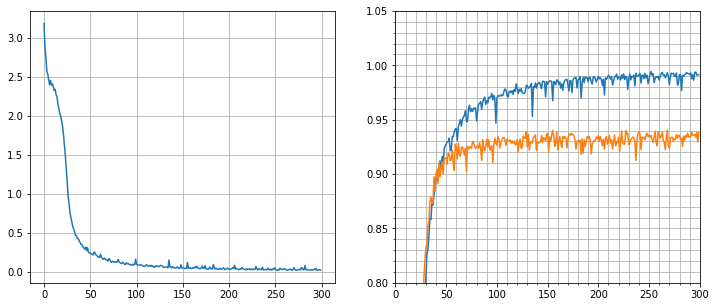

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot([l.cpu() for l in losses][0:300])
plt.grid()

plt.subplot(122)
plt.plot([a.cpu() for a in train_acc][0:300])
plt.plot([a.cpu() for a in test_acc][0:300])
plt.axis([0,300,0.8,1.05])
plt.grid(which='both')
plt.minorticks_on()

In [39]:
for i in avgpool.named_parameters():
    print(i[1].shape)

In [14]:
train_rs.shape

torch.Size([1000, 31, 2000])

In [13]:
from train_gpu import train_mlp_readout
# config.epoch = 300

# reduce frame dimension
train_rs_mlp = train_rs[:,1:,:].mean(1)
test_rs_mlp = test_rs[:,1:,:].mean(1)

mlp = MLP(2*config.N_hid, config.mlp_hid, config.N_out).to(config.device)
train_score, test_score, = train_mlp_readout(model=mlp, 
                                            config=config,
                                            X_train=train_rs_mlp,
                                            X_test=test_rs_mlp,
                                            y_train=train_label,
                                            y_test=test_label)

[1,3000] loss:0.585, train acc:0.8259, test acc:0.8945
[2,3000] loss:0.313, train acc:0.9059, test acc:0.9120
[3,3000] loss:0.265, train acc:0.9218, test acc:0.9165
[4,3000] loss:0.234, train acc:0.9307, test acc:0.9220
[5,3000] loss:0.209, train acc:0.9373, test acc:0.9260
[6,3000] loss:0.189, train acc:0.9440, test acc:0.9300
[7,3000] loss:0.173, train acc:0.9485, test acc:0.9325
[8,3000] loss:0.159, train acc:0.9531, test acc:0.9360
[9,3000] loss:0.147, train acc:0.9564, test acc:0.9395
[10,3000] loss:0.137, train acc:0.9599, test acc:0.9405
[11,3000] loss:0.127, train acc:0.9628, test acc:0.9430
[12,3000] loss:0.118, train acc:0.9659, test acc:0.9405
[13,3000] loss:0.111, train acc:0.9679, test acc:0.9420
[14,3000] loss:0.103, train acc:0.9699, test acc:0.9400
[15,3000] loss:0.097, train acc:0.9724, test acc:0.9400
[16,3000] loss:0.091, train acc:0.9744, test acc:0.9385
[17,3000] loss:0.086, train acc:0.9765, test acc:0.9370
[18,3000] loss:0.081, train acc:0.9780, test acc:0.9355
[

KeyboardInterrupt: 

In [61]:
v = train_rs[index][:,1:,0:config.N_hid]
# v = v.transpose(1,2).view(-1,30)
# node_feat = Egcn(g, v[0:config.N_hid], edge_attr)

In [76]:
train_label[index].view(1,-1)[0]

tensor([0, 3, 4, 7, 0])

In [69]:
v.shape

torch.Size([5, 30, 200])

In [70]:
batch_v = v.transpose(1,2).reshape(-1, 30)
batch_g = dgl.batch([g]*5)
batch_edge_attr = torch.cat(([edge_attr]*5))

In [71]:
node_feat = Egcn(batch_g, batch_v, batch_edge_attr)
# pred = node_feat.argmax(1)

In [73]:
batch_label

NameError: name 'batch_label' is not defined

In [65]:
pred

tensor([5, 8, 5, 5, 9, 9, 9, 8, 8, 9])

In [20]:
for i in transformer_encoder.named_parameters():
    print(i[1].shape)

torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([1536])
torch.Size([512, 512])
torch.Size([512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([512])
torch.Size([1536, 512])
torch.Size([

In [78]:
64*30+64+64*32*32+310+330

68160

In [18]:
batch_f.shape

torch.Size([12, 30])

In [22]:
u = [0,1,2,3,2,5]
v = [1,2,3,4,0,3]
g = dgl.graph((u,v))
g = dgl.add_self_loop(g)

batch_g = dgl.batch([g, g])
feat = torch.ones(6, 3)
batch_f = torch.cat([feat, feat])

edge_weight = torch.tensor([0.5, 0.6, 0.4, 0.7, 0.9, 0.1, 1, 1, 1, 1, 1, 1])
norm = EdgeWeightNorm(norm='both')
norm_edge_weight = norm(g, edge_weight)
conv1 = GraphConv(3, 2, norm='none', weight=True, bias=True, activation=None)
conv2 = GraphConv(3, 2, norm='none', weight=True, bias=True, activation=nn.Softmax())
conv2.weight = conv1.weight
conv2.bias = conv1.bias

# out1 = conv(batch_g, batch_f, edge_weight=norm_edge_weight)
out2 = conv1(batch_g, batch_f, edge_weight=None)
out3 = conv2(batch_g, batch_f, edge_weight=None)
# out3 = conv(g, feat, edge_weight=edge_weight)
# print(out1,'\n', out2, '\n', out3)

c:\ProgramData\Anaconda3\envs\snn\lib\site-packages\dgl\nn\pytorch\conv\graphconv.py:447: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rst = self._activation(rst)


In [23]:
out2,out3

(tensor([[-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-4.7213,  1.2245],
         [-3.1475,  0.8163],
         [-1.5738,  0.4082],
         [-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-3.1475,  0.8163],
         [-4.7213,  1.2245],
         [-3.1475,  0.8163],
         [-1.5738,  0.4082]], grad_fn=<AddBackward0>),
 tensor([[0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0026, 0.9974],
         [0.0186, 0.9814],
         [0.1211, 0.8789],
         [0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0186, 0.9814],
         [0.0026, 0.9974],
         [0.0186, 0.9814],
         [0.1211, 0.8789]], grad_fn=<SoftmaxBackward0>))

In [23]:
a = graph.adjacency_matrix()

TypeError: can't convert Sparse layout tensor to numpy.convert the tensor to a strided layout first.

In [24]:
num_nodes, num_edges = 8, 30
node_dim = 20
edge_dim = 1
graph = dgl.rand_graph(num_nodes, num_edges)
node_feats = torch.rand((num_nodes, node_dim))
edge_feats = torch.rand((num_edges, edge_dim))
egat = EGATConv(in_node_feats=node_dim,
                in_edge_feats=edge_dim,
                out_node_feats=15,
                out_edge_feats=1,
                num_heads=3)
#forward pass
new_node_feats, new_edge_feats = egat(graph, node_feats, edge_feats)
new_node_feats.shape, new_edge_feats.shape

(torch.Size([8, 3, 15]), torch.Size([30, 3, 1]))

In [28]:
new_edge_feats[0]

tensor([[1.7398],
        [2.1219],
        [0.2601]], grad_fn=<SelectBackward0>)

In [29]:
new_edge_feats.mean(1)[0]

tensor([1.3739], grad_fn=<SelectBackward0>)

In [47]:
import dgl.data

dataset = dgl.data.CoraGraphDataset('./data')
print('Number of categories:', dataset.num_classes)
g = dataset[0]
print(g.ndata)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7
{'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'label': tensor([3, 4, 4,  ..., 3, 3, 3]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True]), 'feat': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])}


In [43]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)

In [13]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(30):
        logits = model(g, features)
        pred = logits.argmax(1)
        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
train(g, model)

NameError: name 'GCN' is not defined

In [7]:
from config import Config as config
from RC import torchRC
model = torchRC(config)
mem, spike = model(torch.rand(16, config.frames, 50))
print(mem.shape)

torch.Size([1, 16, 101, 200])


In [45]:
A = model.reservoir.A.numpy()
edge_index = torch.tensor(np.where(A!=0), dtype=torch.long)
edge_attr = torch.tensor(np.array([A[i,j] for i,j in edge_index.T]))
u = edge_index[0]
v = edge_index[1]
mems = mem[0,0,1:].T
g = dgl.graph((u, v))
g.ndata['x'] = mems
g.edata['w'] = edge_attr

h = dgl.graph((u, v))
h.ndata['x'] = mems

In [40]:
g = dgl.graph((u, v))
g.ndata['x'] = mems
g.edata['w'] = edge_attr

h = dgl.graph((u, v))
h.ndata['x'] = mems

In [37]:
from dgl.nn import GraphConv
conv1 = GraphConv(config.frames, 16)
out = conv1(g, mems)
out_h = conv1(h, mems)
print(out_h[0])
print(out[0])

In [47]:
edge_attr

tensor([ 0.3371, -0.0486,  0.0422,  ...,  0.0489, -0.0459,  0.3718])

In [46]:
from torch_geometric.nn import GCNConv
conv2 = GCNConv(100, 16)
conv2(mems, edge_index, edge_attr)

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<AddBackward0>)